In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import os
import glob
import pickle
from operator import itemgetter
from Bio import SeqIO
import csv
import scipy
from scipy import stats
import statsmodels.api as sm
import seaborn as sns


# Initialization

In [3]:
housekeeping_file="/path/to/housekeeping.txt"

samples=["SEQC_A1","SEQC_A2"]

# Predictions

In [4]:
quant_file={}

quant_file["SEQC_A1"]="/path/to/quant.sf"
quant_file["SEQC_A2"]="/path/to/quant.sf"

# Functions

In [5]:
def parse_quant_results(res_file):
    mat=[]
    with open(res_file, 'r') as csv_f:
        spamreader = csv.reader(csv_f, delimiter='\t', quotechar='|')
        cnt=-1
        for row in spamreader:
            cnt+=1
            if cnt==0:
                continue
            mat.append([row[0],int(row[1]),float(row[2]),float(row[4]),float(row[3])])
    return mat

In [6]:
def find_corr(x,y):
    corr={}
    [r,p]=scipy.stats.spearmanr(np.log2(x), np.log2(y))            
    corr['spearman_log']=[r,p]
    return corr



In [7]:
with open(housekeeping_file) as csv_file:
    spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
    hk_genes=[]
    hk_transcripts=[]
    for row in spamreader:
        hk_genes.append(row[0])
        hk_transcripts.append(row[1])
    hk_genes=set(hk_genes)
    hk_transcripts=set(hk_transcripts)    
print len(hk_genes),len(hk_transcripts)

4183 4190


## Read Assembly transcripts

In [8]:
quant_stats={}
median_hk_trans={}
for sample in samples:
    quant_stats[sample]=parse_quant_results(quant_file[sample])
    x_dict={w[0]:w[4] for w in quant_stats[sample] if w[0]}
    hks=[x_dict[k] for k in set(x_dict.keys())&hk_transcripts]
    median_hk_trans[sample]=np.median(hks)            

## Plots

In [9]:
pscnt=1
sample1,sample2=samples
labels=[]
my_data=[]
res1=quant_stats[sample1]
res2=quant_stats[sample2]
x_dict={w[0]:w[4]/float(median_hk_trans[sample1]) for w in res1}
y_dict={w[0]:w[4]/float(median_hk_trans[sample2]) for w in res2}
keys=list(set(x_dict.keys())|set(y_dict.keys()))
keys=filter(lambda x:"ENST" in x,keys)
x=np.array(map(lambda w:x_dict[w] if w in x_dict else 0,keys))
y=np.array(map(lambda w:y_dict[w] if w in y_dict else 0,keys))
x=x+0.5
y=y+0.5
f4=find((np.multiply((y>pscnt),(x>pscnt)))
        +(np.multiply((y>pscnt),(x<=pscnt)))
        +(np.multiply((y<=pscnt),(x>pscnt))))        
w=(np.log2(x[f4])-np.log2(y[f4]))
w=filter(lambda x: abs(x)>=0.000, w)
logfc_data=w

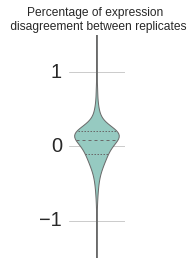

In [10]:
import seaborn as sns
sns.set(style="whitegrid",font_scale=2)
fig, ax = plt.subplots(figsize=(1,4))
my_data=logfc_data
cg=sns.violinplot(data=my_data, palette="Set3" , bw=0.2, cut=10,
               linewidth=1,scale="area",inner="quartile",saturation=0.75,gridsize=500)
ax.set_xticklabels(labels,rotation=90)
ax.set_ylim([-1.5,1.5])
ax.set_yticks(np.arange(-1,2,1))
sns.despine(left=True, bottom=True)    
ax.set_title("Percentage of expression \n disagreement between replicates",fontsize=12)

In [11]:
miss_diff_pscnt={}
sample1,sample2=samples
res1=quant_stats[sample1]
res2=quant_stats[sample2]
x_dict={w[0]:w[4]/float(median_hk_trans[sample1]) for w in res1}
y_dict={w[0]:w[4]/float(median_hk_trans[sample2]) for w in res2}
keys=list(set(x_dict.keys())|set(y_dict.keys()))
keys=filter(lambda x:"ENST" in x,keys)
x=np.array(map(lambda w:x_dict[w] if w in x_dict else 0,keys))
y=np.array(map(lambda w:y_dict[w] if w in y_dict else 0,keys))
for pscnt in np.arange(0,5,0.1):
    zz=find((np.multiply((y<=pscnt),(x<=pscnt))))        
    gg=find((np.multiply((y>pscnt),(x>pscnt)))+
              (np.multiply((y>pscnt),(x<=pscnt)))+
              (np.multiply((x>pscnt),(y<=pscnt))))
    lfc=(np.log2(x[gg]+0.5)-np.log2(y[gg]+0.5))
    miss_diff_pscnt[pscnt]=[sum(np.multiply(abs(lfc)>1,lfc>=0)),
                                         sum(np.multiply(abs(lfc)>1,lfc<0)),
                                         sum(abs(lfc)<=1),
                                         len(zz)
                                        ]


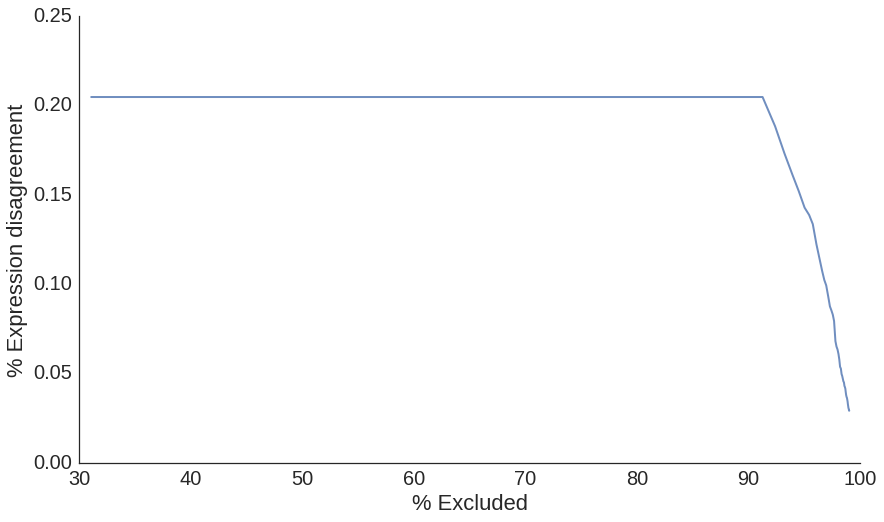

In [12]:
sns.set(style="white",font_scale=2)
fig, ax = plt.subplots(figsize=(14,8))
x=[]
y=[]
for pscnt in np.arange(0,5,0.1):
    md=miss_diff_pscnt[pscnt]
    x.append(md[3]/float(sum(md))*100)
    y.append(sum(md[0:2])/float(sum(md[0:4]))*100)
ax.plot(x,y, alpha=0.8,linewidth=2)
ax.set_xlabel("% Excluded")
ax.set_ylabel("% Expression disagreement")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
